# EVT


Type I EV distribution (Gumbel Distribution):
\begin{align}
F(x) &= e^{-e^{-\frac{1}{a}(x-u)}} 
\end{align}

In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

import statsmodels.api as sm
import scipy.stats as stats

In [2]:
#constants
TEST_DATA_CSV_PATH = "data/annual_maximum_windspeeds.csv"

In [3]:
# load time trace data for pressure sensor
#TODO: put this into a single class for easy manipulation
def load_data(data_csv_path):    
    """ load data into dataframe """
    df = pd.read_csv(data_csv_path, header=None, sep=" ")
    df.drop(columns=2, inplace=True)
    df.columns = ["year", "max_val"]
    return df

def _load_test_data():
    """ load test data into dataframe """
    return load_data(TEST_DATA_CSV_PATH)

df = _load_test_data()
print(df.head())

   year  max_val
0  1952     31.4
1  1953     33.4
2  1954     29.8
3  1955     30.3
4  1956     27.8


c:\program files\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


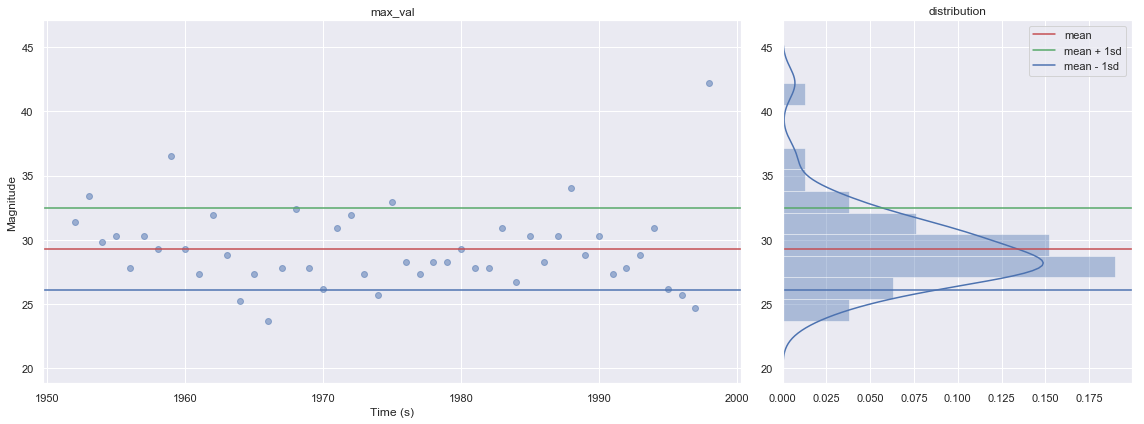

In [4]:
# visualise
# visualise the data 
def visualise(df):
    mean = df['max_val'].mean()
    std = df['max_val'].std()
    
    fig = plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(1, 2, fig, width_ratios=[2,1])

    signal_ax = plt.subplot(gs[0])
    dist_ax = plt.subplot(gs[1], sharey=signal_ax)

    signal_ax.scatter(df['year'], df['max_val'], alpha=0.5); # plot the signal
    signal_ax.axhline(mean, color='r') # plot the mean
    signal_ax.axhline(mean+std, color='g') # plot the mean + 1std
    signal_ax.axhline(mean-std, color='b') # plot the mean - 1std
    
    
    sns.distplot(df['max_val'].values, norm_hist=True, vertical=True, ax=dist_ax); # plot the distribution
    dist_ax.axhline(mean, color='r', label="mean") # plot the mean
    dist_ax.axhline(mean+std, color='g', label="mean + 1sd") # plot the mean + 1std
    dist_ax.axhline(mean-std, color='b', label="mean - 1sd") # plot the mean - 1std
    
    # set labels
    signal_ax.set_title("max_val")
    signal_ax.set_xlabel("Time (s)") 
    signal_ax.set_ylabel("Magnitude")
    
    dist_ax.set_title("distribution")
    dist_ax.set_ylabel(None)
    dist_ax.legend(loc='upper right')

    plt.tight_layout()

# ignore the future warning error about tuples it is from the plot code
visualise(df)

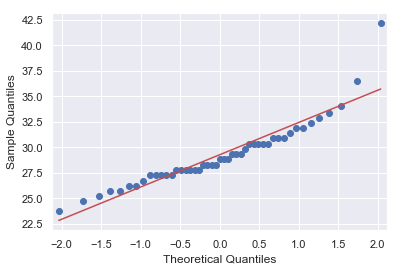

In [9]:
sm.qqplot(df['max_val'], line='s', dist='norm');

In [6]:
df.sort_values(by=['max_val'], inplace=True)
df['rank'] = range(1,len(df)+1)
df['reduced_variate_gumbel'] = -np.log(-np.log(df['rank']/(len(df)+1)))
df['reduced_variate_gringo'] = -np.log(-np.log((df['rank']-0.44)/(len(df)+0.12)))
df.head()

year  max_val  rank  reduced_variate_gumbel  reduced_variate_gringo
14  1966     23.7     1               -1.353565               -1.488967
45  1997     24.7     2               -1.156269               -1.226129
12  1964     25.2     3               -1.019781               -1.069077
22  1974     25.7     4               -0.910235               -0.948927
44  1996     25.7     5               -0.816145               -0.848172

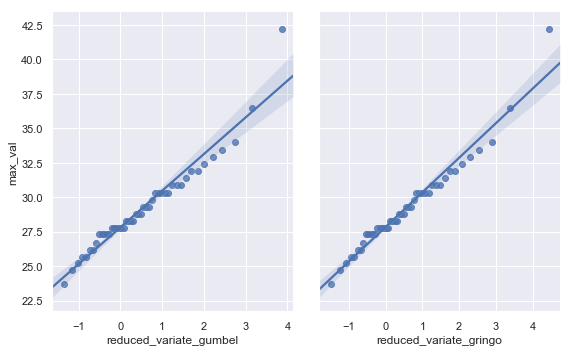

In [7]:
def build_linear_model(y, x, add_constant=True):
    '''
        Linear regression model
        returns the fit model
    '''
    if add_constant:
        x = sm.add_constant(x)
        
    model = sm.OLS(y, x).fit()
    return model 

def fit_evt(df):
    gumbel_model = build_linear_model(df['max_val'], df['reduced_variate_gumbel'], add_constant=True)
    gringo_model = build_linear_model(df['max_val'], df['reduced_variate_gringo'], add_constant=True)
    
    
    sns.pairplot(df, 
                 x_vars=["reduced_variate_gumbel", "reduced_variate_gringo"], 
                 y_vars=["max_val"],
                 height=5, aspect=.8, kind="reg");
    
    #sns.regplot('reduced_variate_gumbel','max_val', data=df)
    #sns.regplot('reduced_variate_gringo','max_val', data=df)
    return gumbel_model, gringo_model

gumbel_model, gringo_model = fit_evt(df)

In [8]:
def predictions(df, gumbel_model, gringo_model, p_array=np.array([10, 20, 50, 100, 200, 500, 1000])):
    
    predictions_df = pd.DataFrame()
    predictions_df["returns"] = p_array
    reduced_variates = -np.log(-np.log(1 - 1/predictions_df["returns"]))

    predictions_df["max_val_gumbel"] = reduced_variates*gumbel_model.params[1] +gumbel_model.params[0]
    predictions_df["max_val_gringo"] = reduced_variates*gringo_model.params[1] +gringo_model.params[0]

    #method of moments
    # TODO: move this elsewhere
    mom_a = np.sqrt(6) /np.pi * df["max_val"].std()
    mom_u = df["max_val"].mean() - 0.5772*mom_a
    
    predictions_df["max_val_moms"] =  reduced_variates*mom_a + mom_u
    
    
    return predictions_df


predictions_df = predictions(df, gumbel_model, gringo_model)
predictions_df.head(7)

returns  max_val_gumbel  max_val_gringo  max_val_moms
0       10       33.794549       33.494466     33.435973
1       20       35.708566       35.303199     35.229992
2       50       38.186064       37.644420     37.552166
3      100       40.042600       39.398835     39.292308
4      200       41.892362       41.146849     41.026100
5      500       44.332772       43.453021     43.313511
6     1000       46.177177       45.195971     45.042281